## Fine-tunning bert cased for Resume Screening.

In [47]:
!pip install evaluate              #for model evaluation

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [48]:
# !pip install wandb                       #for plotting training and result metrics

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [50]:
#import libraries

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments,Trainer
import evaluate
import numpy as np



In [52]:
import pandas as pd
from datasets import Dataset

In [55]:
#load the data
raw_dataset=load_dataset("csv",data_files="/kaggle/input/ai-resume-screening/AI_Resume_Screening.csv")
raw_dataset=raw_dataset['train']

### **Preprocessing**

In [56]:
raw_dataset

Dataset({
    features: ['Resume_ID', 'Name', 'Skills', 'Experience (Years)', 'Education', 'Certifications', 'Job Role', 'Recruiter Decision', 'Salary Expectation ($)', 'Projects Count', 'AI Score (0-100)'],
    num_rows: 1000
})

In [57]:
raw_dataset.features

{'Resume_ID': Value(dtype='int64', id=None),
 'Name': Value(dtype='string', id=None),
 'Skills': Value(dtype='string', id=None),
 'Experience (Years)': Value(dtype='int64', id=None),
 'Education': Value(dtype='string', id=None),
 'Certifications': Value(dtype='string', id=None),
 'Job Role': Value(dtype='string', id=None),
 'Recruiter Decision': Value(dtype='string', id=None),
 'Salary Expectation ($)': Value(dtype='int64', id=None),
 'Projects Count': Value(dtype='int64', id=None),
 'AI Score (0-100)': Value(dtype='int64', id=None)}

In [58]:
panddata=raw_dataset.to_pandas()    #for mergeing the text columns 

In [59]:
panddata

,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100)
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,None,AI Researcher,Hire,104895,8,100
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70
3,4,Elizabeth Carney,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,Hire,46848,0,95
4,5,Julie Hill,"SQL, React, Java",4,PhD,None,Software Engineer,Hire,87441,9,100
...,...,...,...,...,...,...,...,...,...,...,...
995,996,Brenda Williams,"Cybersecurity, Linux, Ethical Hacking",0,B.Sc,None,Cybersecurity Analyst,Reject,114364,9,60
996,997,Colleen Hicks,"Deep Learning, Machine Learning",0,MBA,Deep Learning Specialization,Data Scientist,Reject,103294,5,45
997,998,Michelle Molina,"TensorFlow, NLP",0,B.Tech,Google ML,AI Researcher,Hire,113855,9,65
998,999,Danielle Horn,"Linux, Networking, Cybersecurity, Ethical Hacking",8,PhD,AWS Certified,Cybersecurity Analyst,Hire,83146,10,100


In [60]:
#create class labels column in numeric using map
panddata['labels']=panddata['Recruiter Decision'].map({'Reject':0,'Hire':1})

In [61]:
#merge the text columns
panddata['Resume_details']=panddata[['Skills', 'Experience (Years)', 'Education',
       'Certifications', 'Job Role','Salary Expectation ($)', 'Projects Count', 'AI Score (0-100)']].astype(str).agg(','.join,axis=1)

In [62]:
panddata    #new table with class labels(num) and merged column

,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100),labels,Resume_details
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,None,AI Researcher,Hire,104895,8,100,1,"TensorFlow, NLP, Pytorch,10,B.Sc,None,AI Resea..."
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100,1,"Deep Learning, Machine Learning, Python, SQL,1..."
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70,1,"Ethical Hacking, Cybersecurity, Linux,1,MBA,De..."
3,4,Elizabeth Carney,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,Hire,46848,0,95,1,"Python, Pytorch, TensorFlow,7,B.Tech,AWS Certi..."
4,5,Julie Hill,"SQL, React, Java",4,PhD,None,Software Engineer,Hire,87441,9,100,1,"SQL, React, Java,4,PhD,None,Software Engineer,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Brenda Williams,"Cybersecurity, Linux, Ethical Hacking",0,B.Sc,None,Cybersecurity Analyst,Reject,114364,9,60,0,"Cybersecurity, Linux, Ethical Hacking,0,B.Sc,N..."
996,997,Colleen Hicks,"Deep Learning, Machine Learning",0,MBA,Deep Learning Specialization,Data Scientist,Reject,103294,5,45,0,"Deep Learning, Machine Learning,0,MBA,Deep Lea..."
997,998,Michelle Molina,"TensorFlow, NLP",0,B.Tech,Google ML,AI Researcher,Hire,113855,9,65,1,"TensorFlow, NLP,0,B.Tech,Google ML,AI Research..."
998,999,Danielle Horn,"Linux, Networking, Cybersecurity, Ethical Hacking",8,PhD,AWS Certified,Cybersecurity Analyst,Hire,83146,10,100,1,"Linux, Networking, Cybersecurity, Ethical Hack..."


In [63]:
#convert dataset from pandas dataframe to Hugging Face dataset
final_raw_data=Dataset.from_pandas(panddata)

In [64]:
#train test validation split
final_raw_data=final_raw_data.shuffle(seed=14)
finaldata=final_raw_data.class_encode_column('labels').train_test_split(test_size=0.25,seed=12,stratify_by_column='labels')  #encode numeric column to class column to stratify
valtestdata=finaldata['test']
valtest=valtestdata.train_test_split(test_size=0.5,seed=12)
val=valtest['train']
test=valtest['test']

Stringifying the column:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [65]:
#Tokenizer initialization
checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [67]:
train=finaldata['train']

In [69]:
#Function that returns the tokenized values called by the map function
def tokenize_function(Resume):
  return tokenizer(Resume['Resume_details'],truncation=True)

In [70]:
#applying map function to tokenize each data one at time
tokenized_train=train.map(tokenize_function)

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

In [ ]:
tokenized_train

In [71]:
tokenized_val=val.map(tokenize_function)

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

In [73]:
tokenized_test=test.map(tokenize_function)

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

In [74]:
#For Dynamic Padding
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### **Hyperparameters**

In [75]:
trainingargs=TrainingArguments('test_trainer',num_train_epochs=5,learning_rate=2e-05,weight_decay=0.01,report_to='none',eval_strategy='epoch',)

In [76]:
trainingargs

TrainingArguments(
_n_gpu=2,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [78]:
#to use wandb plotting
# import wandb
# wandb.login(key='apikey') #creating a free account provides api key
# wandb.init(project_name)
#in trainingargs report_to parameter

### **Model**

In [77]:
#initialize model for 2 class labels
model=AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
#metric function given to trainer api to evaluate validation 
def compute_metrics(output):
    prediction,label=output
    pred=np.argmax(output.predictions,axis=-1)
    metrics=evaluate.combine(['accuracy','precision','recall','f1'])
    return metrics.compute(predictions=pred,references=label)
    

### **Trainer API**

In [80]:
trainer=Trainer(
    model,
    trainingargs,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [82]:
trainer.train()  #train the model using initialized trainer

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.056502,1.000000,1.000000,1.000000,1.000000
2,No log,0.001256,1.000000,1.000000,1.000000,1.000000
3,No log,0.000585,1.000000,1.000000,1.000000,1.000000
4,No log,0.000409,1.000000,1.000000,1.000000,1.000000
5,No log,0.000369,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=235, training_loss=0.07168229285706865, metrics={'train_runtime': 59.3297, 'train_samples_per_second': 63.206, 'train_steps_per_second': 3.961, 'total_flos': 78690761103840.0, 'train_loss': 0.07168229285706865, 'epoch': 5.0})

### **Testing**

In [83]:
output=trainer.predict(tokenized_test)     #output prediction for test data


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [84]:
pred=np.argmax(output.predictions,axis=-1)   #predicted output
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [85]:
output.label_ids   #actual output

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [86]:
#evaluation on test data
metrics=evaluate.combine(['accuracy','precision','recall','f1'])
metrics.compute(predictions=pred,references=output.label_ids)

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

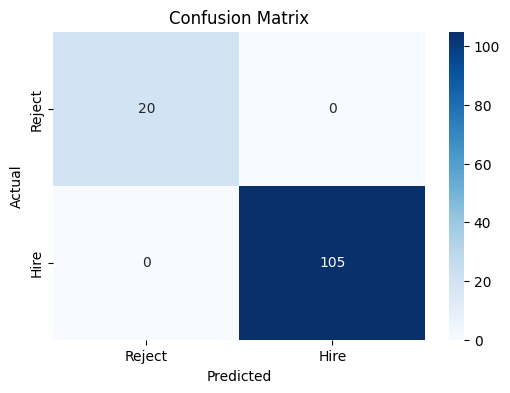

In [87]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(pred, output.label_ids)

# Plot with seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Reject', 'Hire'],
            yticklabels=['Reject', 'Hire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()